# Assignment 2

## Question 1 [15 Pts]:

Suppose data $\{x_i\}_{i = 1}^{i = n}$ is drawn from a normal distribution of _known_ standard deviation $\sigma$ and _unknown_ mean $\mu$
- Derive the MLE estimate $\mu_{\text{MLE}}$
- Derive the MAP estimate $\mu_{\text{MAP}}$ assuming the prior is also a normal distribution with mean $\tau$ and standard deviation $\omega$. What happens as $n \rightarrow \infty$?


## Answer




## Question 2 [30 Pts]:

Consider a Bayesian linear regression model where the outputs $y$ are distributed according to a Gaussian likelihood $p(y\lvert x, \alpha, \beta, \gamma)$ corresponding to a linear model $y = \alpha x + \beta + \epsilon$. Here $\gamma$ represents the noise level in the observed data, i.e. it corresponds to the precision of the data likelihood. In this case, the likelihood can be further expressed as:

$$p(y\lvert x, \alpha, \beta, \gamma) = (\sqrt{\frac{\gamma}{2\pi}})^n\exp(-\frac{\gamma(\sum_{i=1}^n\|y_i - x_i\alpha - \beta\|^2_2)}{2})$$

In a Bayesian setting we would like to assume prior distributions on the unknown parameters $\alpha$, $\beta$ and $\gamma$. Here we assume $p(\alpha) = \mathcal{N}(\mu_{\alpha}, \sigma_{\alpha})$, $p(\beta) = \mathcal{N}(\mu_{\beta}, \sigma_{\beta})$ and $p(\gamma) = \textrm{Gam}(\tau, \omega)$ is a Gamma distribution.

Please write down the posterior conditional distribution for each of those parameters, i.e.,

$p(\alpha\lvert x, y, \beta, \gamma)$

$p(\beta\lvert x, y, \alpha, \gamma)$

$p(\gamma\lvert x, y, \alpha, \beta)$

Comment on your results.

[**HINT**: Might be easier to work with the $\log$ of the posterior, and "complete the square" to identify the distribution]


## Answer

## Question 3 [15 Pts]:

Consider the Bayesian linear regression model with
$$p(y\mid x,w) = \mathcal{N}(y\mid w^{T}\phi(x),\alpha^{-1}I), \ p(w)=\mathcal{N}(w\mid 0,\beta^{-1}I),$$

with $\alpha = 0.5, \beta  = 0.1$. Generate a set of $N = 400$ noisy observations by uniformly sampling

$$y(x) = \sin(\pi x) + \sin(2 \pi x) + \sin(5 \pi x)\quad x\in[-1,1]$$

Once you've created the observations, perturb the data with a normal distribution with standard deviation set to 10% of the data. Compute the MLE and MAP estimates for the weights $w$ using different types and numbers of features $\phi(x)$:
- Monomial basis: $\phi(x) = \{1, x, x^2, x^3, \dots, x^M\}$
- Fourier basis: $\phi(x) = \{0, 1, \sin(\pi x), \cos(\pi x), \sin(2\pi x), \cos(2\pi x), \dots, \sin(M\pi x), \cos(M\pi x)\}$ (this case has a total of $2M$ features)
- [Legendre](https://en.wikipedia.org/wiki/Legendre_polynomials) basis: $\{P_0(x), P_1(x), P_2(x), P_3(x), \dots, P_M(x)\}$, where $P_0(x) = 1, P_1(x) = x$, and subsequent polynomials can be generated by the recursion $(n + 1) P_{n+1} (x) = (2n + 1) x P_n(x) - n P_{n - 1}(x).$

For the case $M=5$, plot the data, the mean predictions corresponding to the MLE and MAP estimates for $w$, and $100$ samples from the predictive posterior distribution.
Which set of features works best for this function and why?

In [133]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as pl

# Create a set of 400 noisy observations -> x & y1
key = jax.random.PRNGKey(42)
X = jax.random.uniform(key, shape=(400,))
y = jnp.sin(jnp.pi*x) + jnp.sin(2*jnp.pi*x) + jnp.sin(5*jnp.pi*x)

# Perturb the data with a normal distribution -> y2
e = jax.random.normal(key, shape=(400,)) * jnp.nanstd(y1, 0)
y = y1 + e

### Computing MLE & MAP estimates:



In [ ]:
# Compute MLE & MAP estimates for weights w
# Used Bayesian linear regression notebook

In [134]:
!pip install --upgrade pyDOE
import jax.numpy as np   
from jax import random
from jax.scipy.stats import norm
from pyDOE import lhs
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


$\begin{aligned}
w_{M L E} & =\left(\phi^T \phi\right)^{-1} \phi^T y, \quad \varphi: \mathbb{R}^d \rightarrow \mathbb{R} . \\
\text { where } \phi & =\left[\varphi_1(x), \ldots, \varphi_m(x)\right] \in \mathbb{R}^{(n \times m)} .
\end{aligned}$

In [140]:
class BayesianLinearRegression:
  """
    Linear regression model: y = (w.T)*x + \epsilon
    w ~ N(0,beta^(-1)I)
    P(y|x,w) ~ N(y|(w.T)*x, alpha^(-1)I)
  """
  def __init__(self, X, y, alpha = 0.5, beta = 0.1):
      # Store training data
      self.X = X.astype(float) # shape: (N, 1)
      self.monophi = np.concatenate((X, np.power(X, 2), np.power(X, 3), np.power(X, 4), np.power(X, 5)), axis = 0) # shape: (N, D)
      self.fourphi = np.concatenate((np.zeros((X.shape[0]),), np.ones((X.shape[0]),), np.sin(np.pi*x), np.cos(np.pi*x), np.sin(2*np.pi*x)), axis = 0) # shape: (N, D)
      self.legephi = np.concatenate((np.zeros((X.shape[0]),), X, (3*np.power(X, 2))/2, (np.power(X,3)*15.0/2 - 2*X)/3, (165.0/6*np.power(X,4) - 22.0/6*np.power(X,2) - 9.0/2*np.power(X,2))/4), axis = 0) # shape: (N, D)
      self.y = y # shape: (N, 1)
      # Store precisions
      self.alpha = alpha
      self.beta = beta
      # Small jitter for numerically stable matrix inversion
      self.jitter = 1e-8

  # Computes the MLE estimate of the regression weights
  def fit_MLE_mono(self):
      xTx_inv = np.linalg.inv(np.matmul(self.monophi.T,self.X) + self.jitter*np.eye(self.monophi.shape[1]))
      xTy = np.matmul(self.monophi.T, self.y)
      w_MLE = np.matmul(xTx_inv, xTy)
      self.w_MLE = w_MLE
      return w_MLE

  # Computes the MAP estimate of the regression weights
  def fit_MAP(self):
      Lambda = np.matmul(self.monophi.T,self.monophi) + \
               (self.beta/self.alpha)*np.eye(self.monophi.shape[1])
      Lambda_inv = np.linalg.inv(Lambda)
      xTy = np.matmul(self.monophi.T, self.y)
      mu = np.matmul(Lambda_inv, xTy)
      self.w_MAP = mu
      self.Lambda_inv = Lambda_inv
      return mu, Lambda_inv

  # Computes the predictive posterior distribution
  def predictive_distribution(self, X_star):
      mean_star = np.matmul(X_star, self.w_MAP)
      var_star = np.eye(X_star.shape[1])/self.alpha + \
                 np.matmul(X_star, np.matmul(self.Lambda_inv, X_star.T))
      return mean_star, var_star


In [139]:
model = BayesianLinearRegression(X, y)
# Fit MLE and MAP estimates for w
w_MLE = model.fit_MLE_mono()
w_MAP, Lambda_inv = model.fit_MAP_mono()

ValueError: ignored

## Question 4 [20 Pts]:

Write a logistic regression model to classify the letters from the [EMNIST](https://www.nist.gov/itl/products-and-services/emnist-dataset) letters dataset. Create an 80/20 train/test split of the data. You've been provided a template to carry this out. Fill in the suitable sections of the code.

- First train your model to perform binary classification between the letters b and d. Visualize performance on the training and test sets using a confusion matrix.
- Next, train your model to perform multiclass classification between b, d, p and q. Visualize performance on the training and test sets using a confusion matrix. 

In [ ]:
import torchvision
import jax.numpy as jnp
import jax
import matplotlib.pyplot as pl
import seaborn as sns
from sklearn import metrics

In [ ]:
dataset = torchvision.datasets.EMNIST(root='./', split='letters', train=True, download=True)

In [ ]:
X = jnp.array(dataset.data) # shape: 124800, 28, 28
y = jnp.array(dataset.targets) # shape: 124800 (letters -> 1 to 26)

# Get letter b, d, p and q from the dataset
b_ind = jnp.argwhere(jnp.isin(y, 2)).ravel()
d_ind = jnp.argwhere(jnp.isin(y, 4)).ravel()
p_ind = jnp.argwhere(jnp.isin(y, 16)).ravel()
q_ind = jnp.argwhere(jnp.isin(y, 17)).ravel()

# Combine them below to create datasets for usage in following parts:

# create X_bd, Y_bd for binary classification
X_bd = jnp.concatenate((X[b_ind,:,:], X[d_ind,:,:]))
y_bd = jnp.concatenate((y[b_ind]-2, y[d_ind]-3))

# create X_bdpq, Y_bdpq for multiclass classification
X_bdpq = jnp.concatenate((X[b_ind,:,:], X[d_ind,:,:], X[p_ind,:,:], X[q_ind,:,:]))
y_bdpq = jnp.concatenate((y[b_ind]-2, y[d_ind]-3, y[p_ind]-14, y[q_ind]-14))

In [ ]:
X_bd.shape
y_bd.shape

(9600,)

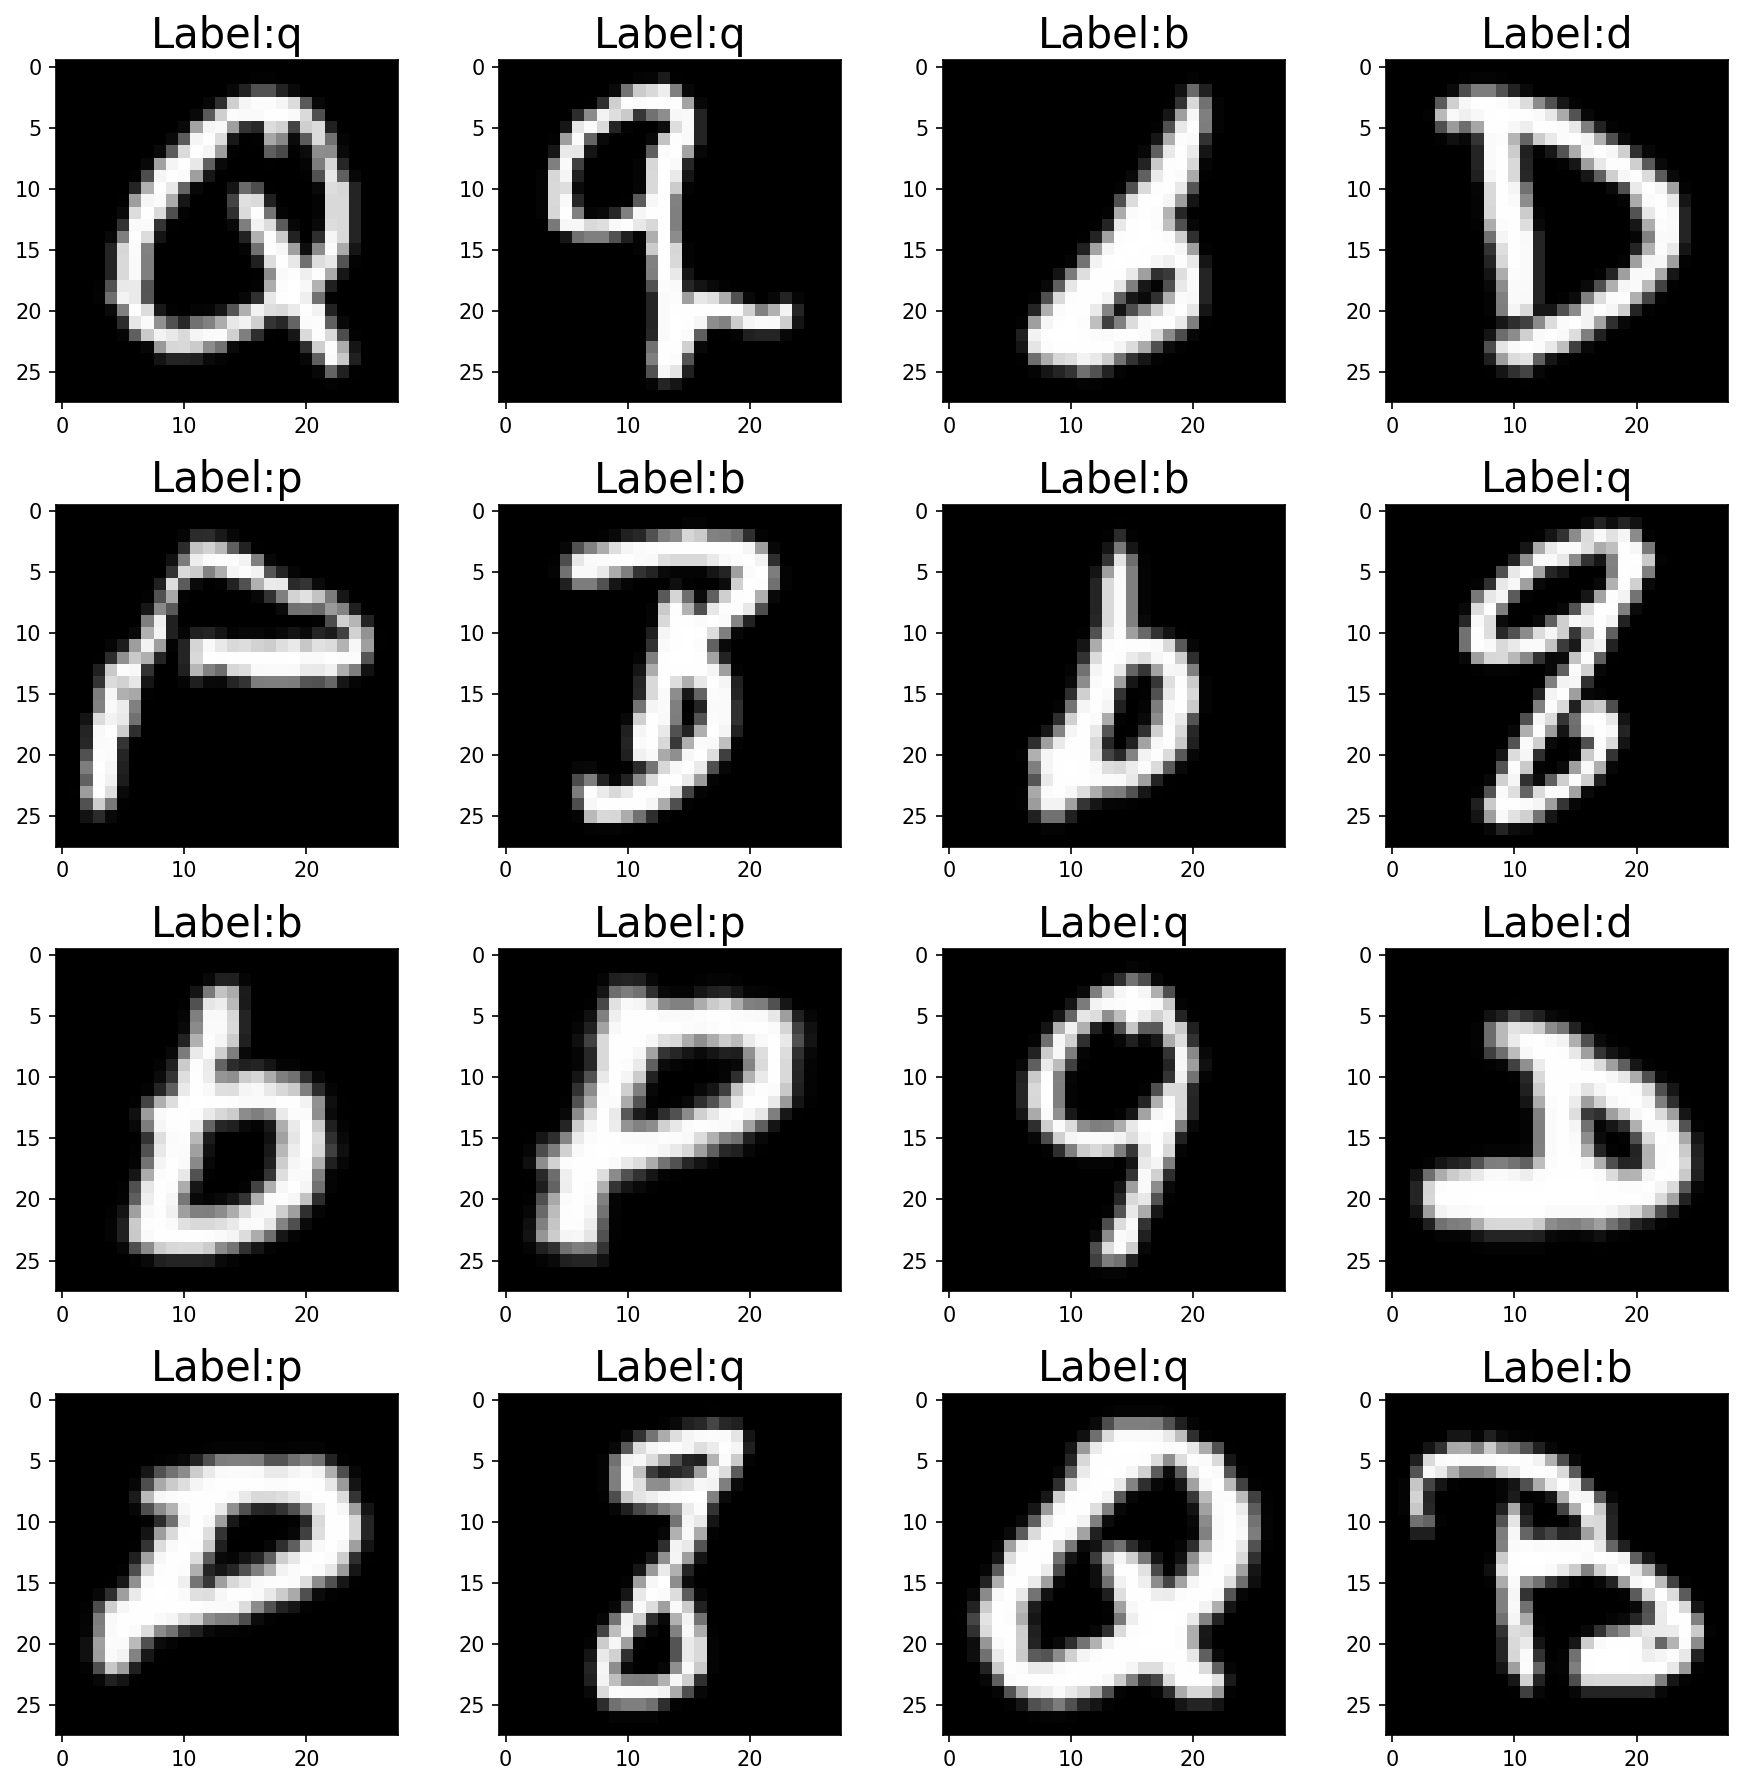

In [ ]:
# Check that the mapping was performed correctly by utilizing a few examples:
# Visualizing that your mapping is performed correctly
rnd_idx = jax.random.randint(jax.random.PRNGKey(42), (16,), 0, X_bdpq.shape[0])
# assuming that the labels are mapped as follows: b -> 0, d -> 1, p -> 2, q -> 3 (change if you're using something different)
str_labels = ['b', 'd', 'p', 'q']
pl.figure(dpi = 150, figsize=(12,12))
for index, (image, label) in enumerate(zip(X_bdpq[rnd_idx], y_bdpq[rnd_idx])):
    pl.subplot(4, 4, index + 1)
    pl.imshow(jnp.reshape(image, (28,28)).T, cmap=pl.cm.gray)
    pl.title('Label:' + str_labels[int(label)], fontsize = 20)
pl.tight_layout()

In [ ]:
# Fill in the code to perform an 80-20 train-test split on X_bd and y_bd to yield X_train, y_train, X_test, y_test:

key = jax.random.PRNGKey(42)
shuffle = jax.random.permutation(key, X_bd.shape[0])
train = int(.8 * X_bd.shape[0])
test = X_bd.shape[0] - train

X_train = X_bd[shuffle[:train],:,:].reshape(train, 28*28) # shape = (7680, 784)
y_train = y_bd[shuffle[:train]] # shape = (7680,)
X_test = X_bd[shuffle[train:],:,:].reshape(test, 28*28)
y_test = y_bd[shuffle[train:]]

Binary cross-entropy loss formula: $-\frac{1}{n}\sum _{i=1}^n\left(y_i\log \alpha _i+\left(1-y_i\right)\log \left(1-\alpha _i\right)\right)$

In [ ]:
def forward(params, X):
    """
    X: shape (7680, 784)
    params: shape (7680,)
    returns: shape (7680, 1)
    """
    return jax.nn.sigmoid(X @ params)

@jax.jit
def loss_fn(params, X, y):
    """
    X: shape (7680, 784)
    params: shape (7680,)
    """
    # fill this in to compute and return the binary cross entropy loss
    y_hat = forward(params, X).squeeze() # shape (7480,)
    loss_wo_sum = (y * jnp.log(y_hat)) + ((1-y)*jnp.log(1-y_hat)) # shape (7480,)
    loss = -1 * jnp.mean(loss_wo_sum) # shape ()
    return loss

# Computing Gradients:
grad_loss = jax.jit(jax.grad(loss_fn))

# QUESTION: DOES DOING SQUEEZE MESS WITH THE GRADIENT CALCULATION??

In [ ]:
# Initializing weights as zeros:
params = jnp.zeros([784, 1])

# Gradient descent
# Learning Rate
alpha = 5e-7
n_its = 5000

loss_history = [loss_fn(params, X_train, y_train)]
for i in range(n_its):
    g      = grad_loss(params, X_train, y_train)
    params = jax.tree_map(lambda x, g: x - alpha * g, params, g)

    # Track progress:
    loss_history = loss_history + [loss_fn(params, X_train, y_train)]

Text(0.5, 0, 'Number of Iterations')

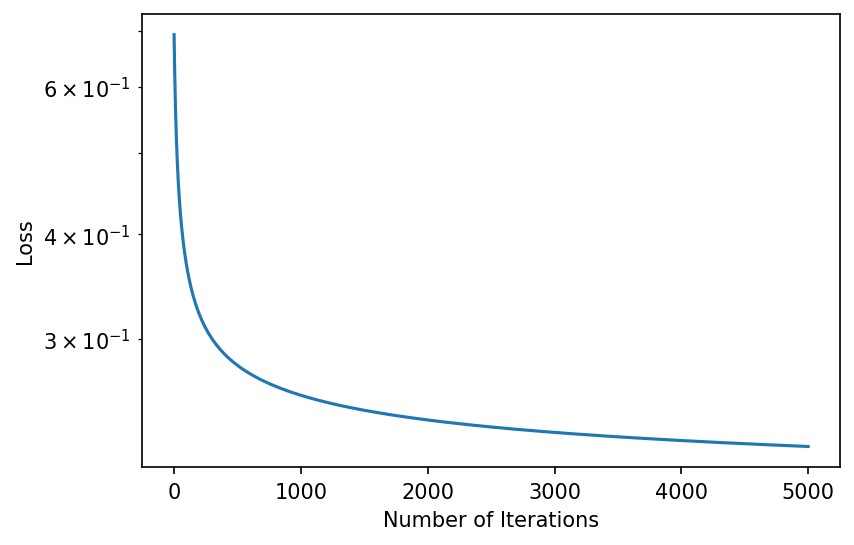

In [ ]:
# Plotting the loss history
pl.figure(dpi = 150)
pl.semilogy(loss_history)
pl.ylabel('Loss')
pl.xlabel('Number of Iterations')

In [ ]:
# Computing Accuracy Score and Resulting Confusion Matrix for test set:
accuracy_score = (jnp.round(forward(params, X_test)).ravel() == y_test).mean()
cm             = metrics.confusion_matrix(y_test, jnp.round(forward(params, X_test)))
cm_normalized  = cm.astype('float') / cm.sum(axis=1)[:, jnp.newaxis]

print('Accuracy Score on Test Set:', accuracy_score)

Accuracy Score on Test Set: 0.9125


Text(0.5, 1.0, 'Confusion Matrix')

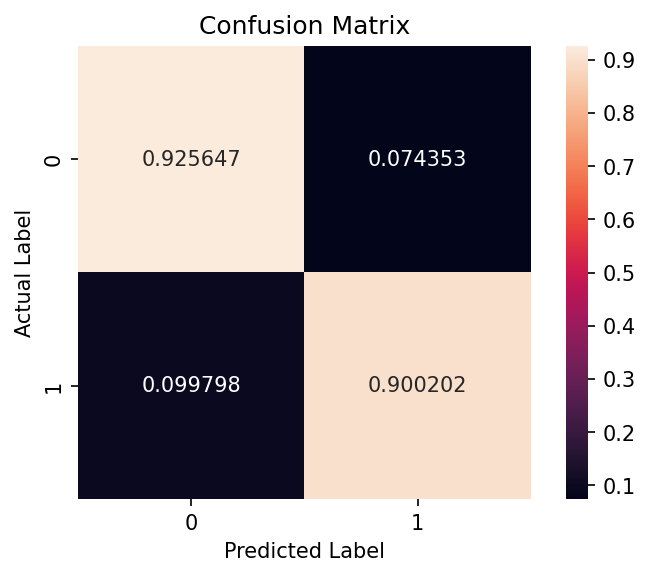

In [ ]:
pl.figure(dpi = 150)
sns.heatmap(cm_normalized, fmt = '4f', annot = True, square = True);
pl.ylabel('Actual Label');
pl.xlabel('Predicted Label');
pl.title('Confusion Matrix')

In [ ]:
# Fill in the code to perform an 80-20 train-test split on X_bdpq and y_bdpq to yield X_train, y_train, X_test, y_test:

# Remember that you need to be one hot encoding the labels for multiclass classification
"""
From 1->b, 2->d, 3->p, 4->q to:
[1 0 0 0] -> b
[0 1 0 0] -> d
[0 0 1 0] -> p
[0 0 0 1] -> q
"""

shuffle = jax.random.permutation(key, X_bdpq.shape[0])
train = int(.8 * X_bdpq.shape[0])
test = X_bdpq.shape[0] - train

X_train = X_bdpq[shuffle[:train],:,:].reshape(train, 28*28)
y_train = jax.nn.one_hot(y_bdpq[shuffle[:train]], 4)
X_test = X_bdpq[shuffle[train:],:,:].reshape(test, 28*28)
y_test = jax.nn.one_hot(y_bdpq[shuffle[train:]], 4)

In [ ]:
def forward(params, X):
    return jax.nn.softmax(X @ params)

@jax.jit
def loss_fn(params, X, y):
    # fill this in to compute and return the binary cross entropy loss
    y_hat = forward(params, X).squeeze() # shape (15360, 784)
    loss_wo_sum = (y * jnp.log(y_hat)) + ((1-y)*jnp.log(1-y_hat)) # shape (15360, 784)
    loss = -1 * jnp.mean(loss_wo_sum) # shape ()
    return loss

# Computing Gradients:
grad_loss = jax.jit(jax.grad(loss_fn))

In [ ]:
# Shape inspecting

# print(y_train.shape)
# print(X_train.shape)
# params = jnp.zeros([784, 4])
# y_hat = forward(params, X_train) # shape = (15360, 784)
# print(y_hat.shape)

# print(jnp.log(y_hat).shape)

# print((y_train * jnp.log(y_hat)).shape)
# print(((1-y_train)*jnp.log(1-y_hat)).shape)

# loss_wo_sum = (y_train * jnp.log(y_hat)) + ((1-y_train)*jnp.log(1-y_hat))
# print(loss_wo_sum.shape)
# sdj = jnp.mean(loss_wo_sum)
# sdj.shape

(15360, 4)
(15360, 784)
(15360, 4)
(15360, 4)
(15360, 4)
(15360, 4)
(15360, 4)


()

In [ ]:
# Initializing weights as zeros:
params = jnp.zeros([784, 4])

# Gradient descent
# Learning Rate
alpha = 6e-7
n_its = 5000

loss_history = [loss_fn(params, X_train, y_train)]
for i in range(n_its):
    g      = grad_loss(params, X_train, y_train)
    params = jax.tree_map(lambda x, g: x - alpha * g, params, g)

    # Track progress:
    loss_history = loss_history + [loss_fn(params, X_train, y_train)]

Text(0.5, 0, 'Number of Iterations')

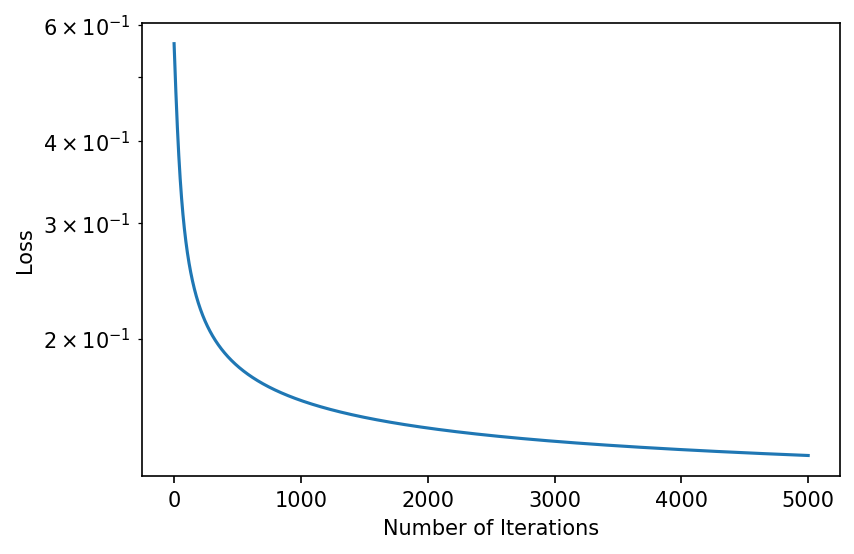

In [ ]:
pl.figure(dpi = 150)
pl.semilogy(loss_history)
pl.ylabel('Loss')
pl.xlabel('Number of Iterations')

In [ ]:
# Computing Accuracy Score and Resulting Confusion Matrix for test set:
accuracy_score = (jnp.argmax(forward(params, X_test), axis = 1) == 
                  jnp.argmax(y_test, axis = 1)).mean()
cm             = metrics.confusion_matrix(jnp.argmax(y_test, axis = 1), 
                                          jnp.argmax(forward(params, X_test), axis = 1))
cm_normalized  = cm.astype('float') / cm.sum(axis=1)[:, jnp.newaxis]
print('Accuracy Score on Test Set:', accuracy_score)

Accuracy Score on Test Set: 0.9044271


Text(0.5, 1.0, 'Confusion Matrix')

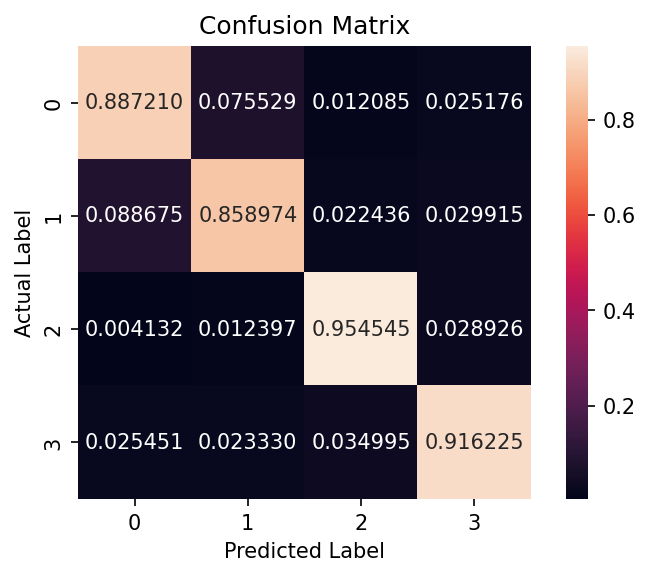

In [ ]:
pl.figure(dpi = 150)
sns.heatmap(cm_normalized, fmt = '4f', annot = True, square = True);
pl.ylabel('Actual Label');
pl.xlabel('Predicted Label');
pl.title('Confusion Matrix')

## Question 5 [20 Pts]:
Write Python routines:
- `gradient_descent(f, g, x0, eta)` that performs an iteration of gradient descent on a given function $f(x)$ and its gradient $g(x)$, starting at a given point $x_0$, and using a given step-size $\eta$.
- `newton(f, g, H, x0, eta)` that performs an iteration of Newton's method on a given function $f(x)$, its gradient $g(x)$ and Hessian $H(x)$, starting at a given point $x_0$, and using a given step-size $\eta$.

Do **NOT** use `jax.grad` or `jax.hessian` (you need to define the gradient and Hessian functions). Use those routines in an optimization loop to optimize the following two functions:

- $$f_1(x, y) = x^2 + 100 y^2 $$
- $$f_2(x, y) = (1 - x)^2 + 100(y - x^2)^2,$$

Consider step-sizes $\eta = 0.001, 0.01, 1$. Take your initial starting location as $(-1, 1)$. Comment on the following: 
- What is the effect of step-size on the different problems, and algorithms? 
- When the algorithm does converge, how many steps does it take to reach the minimum?

Give suitable reasons for your observations. Plot the objective function value vs the iterate number, and a plot that shows the progress on a contour plot of the landscape. Use these to support your reasoning.

In [ ]:
# your code here

def gradient_descent(f, g, x0, eta):
  ...

def newton(f, g, H, xo, eta)
  ...

